# Sonoran Desert: ERA5
#### Discharge in 1990-2000
Simulation of the discharge of the Gila River in 2024, using the historical data of ERA5. The camel that is used for this notebook is: hysets_09488650

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
import fiona
import shapely.geometry
from pyproj import Geod
from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

### Setting up the model ERA5
Creating the parameter dataset and the forcing dataset at the Gila River, near Yuma. Next, these datasets are used to set up the pcrglobwb model.

In [2]:
station_latitude = [32.76336494699427, 32.88909499784028, 32.684089485789755, 32.865669088682274, 32.719162360122446, 32.828650757990125, 32.756881878799334, 32.82063561463508, 32.60777730703933, 32.67058677793268, 32.94848416830013]
station_longitude = [-114.55114003114731, -114.5017866074773, -114.51809096391581, -113.9776363724262, -114.07727215815218, -113.85359656233821, -114.01646418905023, -113.60895076390092,  -114.10631164360657, -113.76005959016287, -113.35280271756335]

In [3]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory= "/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)

In [4]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonorandesert2/work/diagnostic/script",
)

In [5]:
pcrglob = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing
)

In [6]:
cfg_file, cfg_dir = pcrglob.setup(
    start_time="1990-01-01T00:00:00Z",
    end_time="2000-01-01T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file, cfg_dir

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250110_122243/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250110_122243')

In [7]:
pcrglob.initialize(cfg_file)

In [8]:
time = pd.date_range(pcrglob.start_time_as_isostr, pcrglob.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

recharge = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

discharge = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

In [9]:
while pcrglob.time < pcrglob.end_time:
    pcrglob.update()

    # Track discharge for all station locations
    time = pcrglob.time_as_isostr  # Current time as ISO string
    for i in range(len(station_latitude)):
        # Fetch discharge for the current station
        discharge_at_station = pcrglob.get_value_at_coords(
            "discharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        precipitation_at_station = pcrglob.get_value_at_coords(
            "precipitation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        landsurface_at_station = pcrglob.get_value_at_coords(
            "land_surface_runoff", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
    
        evaporation_at_station = pcrglob.get_value_at_coords(
            "total_evaporation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        abstraction_at_station = pcrglob.get_value_at_coords(
            "total_groundwater_abstraction", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
        
        recharge_at_station = pcrglob.get_value_at_coords(
            "groundwater_recharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        # Use a unique key for each station in timeseries
        station_key = f"PCRGlobWB: Station {i+1}"  # Dynamic station key
        if station_key not in timeseries:
            timeseries[station_key] = {}  

        if station_key not in recharge:
            recharge[station_key] = {}
        
        if station_key not in discharge:
            discharge[station_key] = {}
        
        # Store the discharge value for the current time
        timeseries[station_key][time] = precipitation_at_station[0] + landsurface_at_station[0] - evaporation_at_station[0] - abstraction_at_station[0] 
        recharge[station_key][time] = recharge_at_station[0]
        discharge[station_key][time] = discharge_at_station[0]

    # Show progress
    #print(time, end='\r')  # Uncomment for real-time progress display


In [12]:
approx = pd.DataFrame(timeseries)
approx.to_csv('approx1990_2000.csv')

Q = pd.DataFrame(discharge)
Q.to_csv('discharge1990_2000.csv')

r = pd.DataFrame(recharge)
r.to_csv('recharge1990_2000.csv')

<Axes: title={'center': 'Discharge (2010-2020)'}, xlabel='time', ylabel='Discharge [mm/day]'>

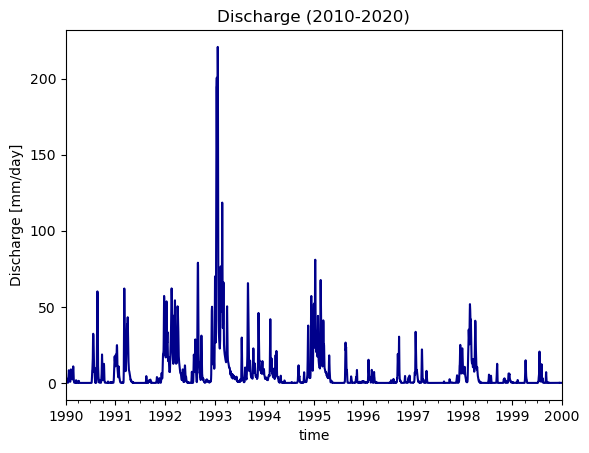

In [18]:
Q = pd.DataFrame(discharge)
Q['Discharge'] = Q.mean(axis=1) * 86400 * 1000 / (388.541*10**6)
Q['Discharge'].plot(title='Discharge (1990-2000)', ylabel='Discharge [mm/day]', color="darkblue")

<Axes: title={'center': 'Approximation Groundwater Recharge ERA5 (1990-2000)'}, xlabel='time', ylabel='Recharge [mm/day]'>

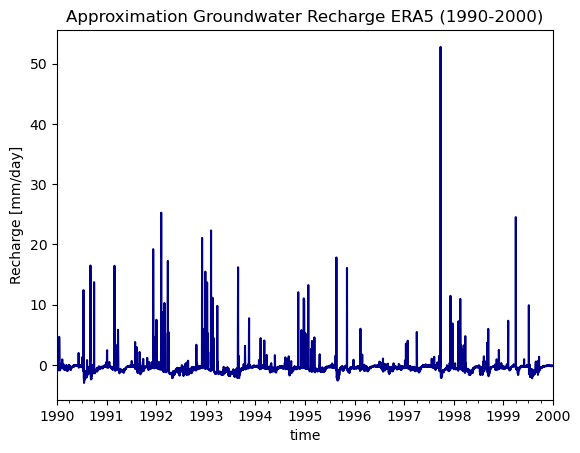

In [19]:
approx = pd.DataFrame(timeseries)
approx['Approximation Groundwater Recharge'] = approx.mean(axis=1)*1000 - Q['Discharge'].min()
approx['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge ERA5 (1990-2000)', ylabel = 'Recharge [mm/day]', color="darkblue")

<Axes: title={'center': 'Groundwater Recharge PCRGlob-WB ERA5 (1990-2000)'}, xlabel='time', ylabel='Recharge [mm/day]'>

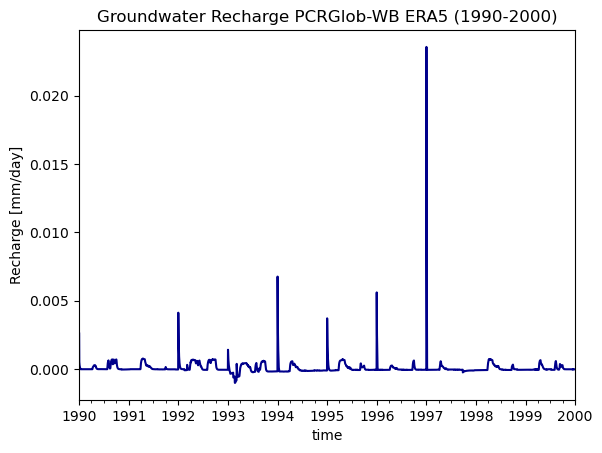

In [15]:
r = pd.DataFrame(recharge)
r['Groundwater Recharge'] = r.mean(axis=1)*1000
r['Groundwater Recharge'].plot(title='Groundwater Recharge PCRGlob-WB ERA5 (1990-2000)', ylabel = 'Recharge [mm/day]', color="darkblue")

In [20]:
pcrglob.finalize()